<a href="https://colab.research.google.com/github/mrdbourke/pytorch-deep-learning/blob/main/extras/exercises/03_pytorch_computer_vision_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 03. PyTorch Computer Vision Exercises

The following is a collection of exercises based on computer vision fundamentals in PyTorch.

They're a bunch of fun.

You're going to get to write plenty of code!

## Resources

1. These exercises are based on [notebook 03 of the Learn PyTorch for Deep Learning course](https://www.learnpytorch.io/03_pytorch_computer_vision/). 
2. See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/_PibmqpEyhA). 
  * **Note:** Going through these exercises took me just over 3 hours of solid coding, so you should expect around the same.
3. See [other solutions on the course GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions).

In [56]:
%pip -q install torch torchvision torchaudio torchmetrics pandas numpy matplotlib tqdm scikit-learn mlxtend;


[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [57]:
# Import torch
import torch
from torch import nn
from torchvision.transforms import ToTensor
import numpy as np
import matplotlib.pyplot as plt

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device = "mps" if torch.backends.mps.is_available() else device


# Setup random seed
def seed_everything(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True


seed_everything()

## 5. Load the [`torchvision.datasets.MNIST()`](https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html#torchvision.datasets.MNIST) train and test datasets.

In [58]:
from torchvision.datasets import MNIST

train_data = MNIST(
    root="data", train=True, download=True, transform=ToTensor(), target_transform=None
)
test_data = MNIST(
    root="data", train=False, download=True, transform=ToTensor(), target_transform=None
)

## 6. Visualize at least 5 different samples of the MNIST training dataset.

Train data shape: torch.Size([60000, 28, 28])
Test data shape: torch.Size([10000, 28, 28])
Number of classes: 10
Classes: ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']


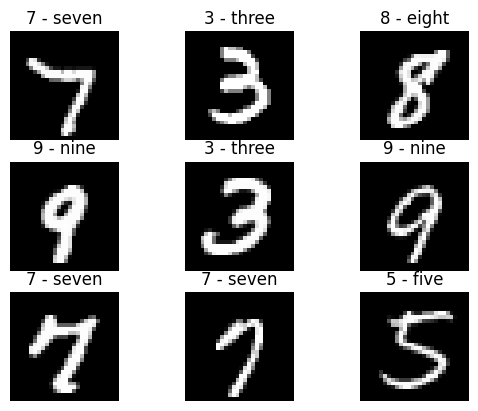

In [59]:
def plot_samples(data, n_samples=9):
    n_samples = 9
    sample_indices = np.random.choice(len(train_data), n_samples, replace=False)
    sample_images = data.data[sample_indices]
    sample_targets = data.targets[sample_indices]
    classes = data.classes
    sample_classes = [classes[target] for target in sample_targets]

    for i in range(n_samples):
        plt.subplot(3, 3, i + 1)
        img = sample_images[i].cpu()
        label = sample_classes[i]
        plt.imshow(img, cmap="gray")
        plt.title(f"{label}")
        plt.axis("off")


classes = train_data.classes
print(f"Train data shape: {train_data.data.shape}")
print(f"Test data shape: {test_data.data.shape}")
print(f"Number of classes: {len(classes)}")
print(f"Classes: {classes}")
plot_samples(train_data)

## 7. Turn the MNIST train and test datasets into dataloaders using `torch.utils.data.DataLoader`, set the `batch_size=32`.

In [60]:
from torch.utils.data import DataLoader

batch_size = 64
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=False)

## 8. Recreate `model_2` used in notebook 03 (the same model from the [CNN Explainer website](https://poloclub.github.io/cnn-explainer/), also known as TinyVGG) capable of fitting on the MNIST dataset.

In [61]:
class TinyVGG(nn.Module):
    def __init__(self, input_channels, hidden_channels, output_channels):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_channels, hidden_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_channels, hidden_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(hidden_channels, hidden_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_channels, hidden_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(), nn.Linear(7 * 7 * hidden_channels, output_channels)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        y = self.classifier(x)
        return y

## 9. Train the model you built in exercise 8. for 5 epochs on CPU and GPU and see how long it takes on each.

In [62]:
from tqdm import tqdm
import time


def train(model, dataloader, epochs, loss_fn, optimizer, acc_fn, device):
    start_time = time.perf_counter()
    for epoch in tqdm(range(epochs)):
        print(f"Epoch: {epoch+1}/{epochs}")
        print("-" * 30)
        model.train()
        model.to(device)
        acc_fn.to(device)

        loss, acc = 0, 0
        for X, Y in dataloader:
            X, Y = X.to(device), Y.to(device)

            Y_logits = model(X)
            batch_loss = loss_fn(Y_logits, Y)
            batch_acc = acc_fn(Y_logits, Y)

            loss, acc = loss + batch_loss, acc + batch_acc

            optimizer.zero_grad()
            batch_loss.backward()
            optimizer.step()

        loss, acc = loss / len(dataloader), acc / len(dataloader) * 100

        print(f"Train loss: {loss:.3f}, Train accuracy: {acc:.3f}%")
        print("-" * 30)
    end_time = time.perf_counter()
    print(f"Training took {end_time-start_time:.2f} seconds")


def test(model, dataloader, loss_fn, acc_fn, device):
    start_time = time.perf_counter()
    model.eval()
    model.to(device)
    acc_fn.to(device)

    with torch.inference_mode():
        loss, acc = 0, 0
        for X, Y in dataloader:
            X, Y = X.to(device), Y.to(device)

            Y_logits = model(X)
            batch_loss = loss_fn(Y_logits, Y)
            batch_acc = acc_fn(Y_logits, Y)

            loss, acc = loss + batch_loss, acc + batch_acc

        loss, acc = loss / len(dataloader), acc / len(dataloader) * 100

    print(f"Test loss: {loss:.3f}, Test accuracy: {acc:.3f}%")
    print("-" * 30)
    end_time = time.perf_counter()
    print(f"Testing took {end_time-start_time:.2f} seconds")

In [63]:
from torchmetrics import Accuracy

model = TinyVGG(input_channels=1, hidden_channels=10, output_channels=len(classes)).to(
    device
)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
acc_fn = Accuracy(task="multiclass", num_classes=len(classes))

train(
    model,
    train_dataloader,
    epochs=5,
    loss_fn=loss_fn,
    optimizer=optimizer,
    acc_fn=acc_fn,
    device=device,
)
test(model, test_dataloader, loss_fn=loss_fn, acc_fn=acc_fn, device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1/5
------------------------------


 20%|██        | 1/5 [00:09<00:37,  9.26s/it]

Train loss: 0.176, Train accuracy: 94.505%
------------------------------
Epoch: 2/5
------------------------------


 40%|████      | 2/5 [00:18<00:27,  9.13s/it]

Train loss: 0.081, Train accuracy: 97.523%
------------------------------
Epoch: 3/5
------------------------------


 60%|██████    | 3/5 [00:27<00:17,  9.00s/it]

Train loss: 0.071, Train accuracy: 97.773%
------------------------------
Epoch: 4/5
------------------------------


 80%|████████  | 4/5 [00:35<00:08,  8.90s/it]

Train loss: 0.066, Train accuracy: 97.929%
------------------------------
Epoch: 5/5
------------------------------


100%|██████████| 5/5 [00:44<00:00,  8.93s/it]

Train loss: 0.064, Train accuracy: 97.998%
------------------------------
Training took 44.64 seconds


Test loss: 0.057, Test accuracy: 98.298%
------------------------------
Testing took 0.87 seconds


## 10. Make predictions using your trained model and visualize at least 5 of them comparing the prediciton to the target label.

In [64]:
def plot_predictions(model, data):
    n_samples = 9
    sample_indicies = np.random.choice(len(data), n_samples, replace=False)
    sample_images = data.data[sample_indicies]
    sample_targets = data.targets[sample_indicies]
    classes = data.classes
    sample_classes = [classes[target] for target in sample_targets]

    model.eval()
    with torch.inference_mode():
        sample_images = sample_images.float().to(device).unsqueeze(1)
        sample_targets = sample_targets.to(device)
        sample_logits = model(sample_images)
        sample_predictions = torch.argmax(sample_logits, dim=1)

    for i in range(n_samples):
        plt.subplot(3, 3, i + 1)
        img = sample_images[i].squeeze().cpu()
        label = sample_classes[i]
        pred = classes[sample_predictions[i]]
        plt.imshow(img, cmap="gray")
        color = "green" if label == pred else "red"
        plt.title(f"{pred}", color=color)
        plt.axis("off")

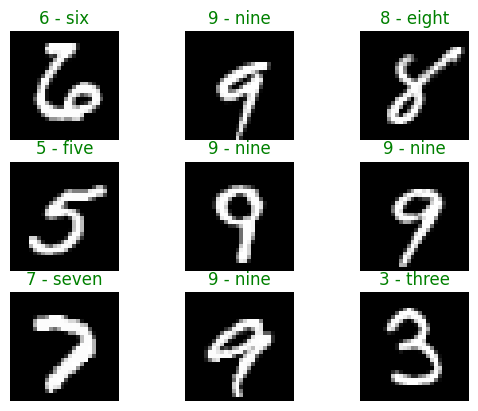

In [65]:
plot_predictions(model, test_data)

## 11. Plot a confusion matrix comparing your model's predictions to the truth labels.

In [66]:
model.eval()
with torch.inference_mode():
    Y_test_preds = []
    for X, Y in test_dataloader:
        X = X.to(device)
        Y_logits = model(X)
        Y_pred = torch.argmax(Y_logits, dim=1)
        Y_test_preds.append(Y_pred)

    Y_test_preds = torch.cat(Y_test_preds)

(<Figure size 1000x700 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

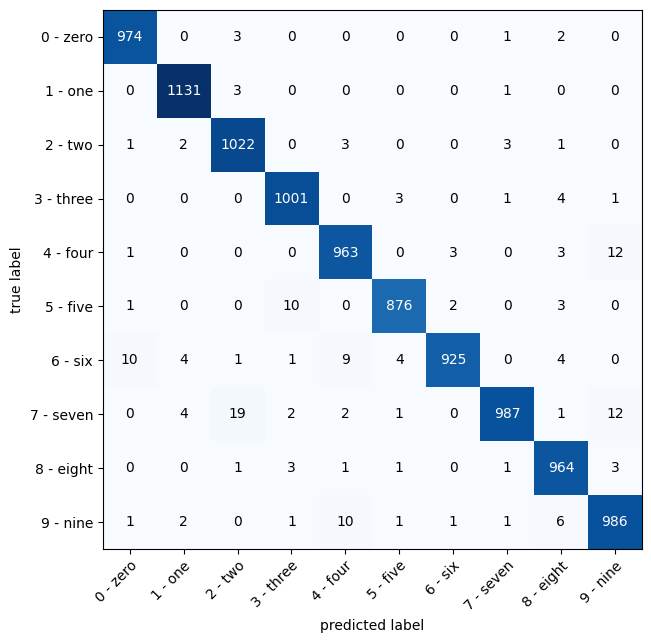

In [67]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

cm = ConfusionMatrix(num_classes=len(classes), task="multiclass").to(device)
cm = cm(Y_test_preds, test_data.targets.to(device))
plot_confusion_matrix(cm.cpu().numpy(), figsize=(10, 7), class_names=classes)